In [1]:
%matplotlib inline

In [2]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [3]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSION = "group13_a"

VISUAL_INSPECTION = False

In [4]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = RAW_DATA_PATH.joinpath(SESSION + ".vhdr"),
    eog = ("HEOG", "VEOG"),
    misc = ("41",),
    preload = True,
    verbose = False
)

raw.info

/tmp/ipykernel_2448/1274395445.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(


Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


In [5]:
if SESSION == "group13_c":
    raw.crop(tmin = 1915, tmax = 2300)

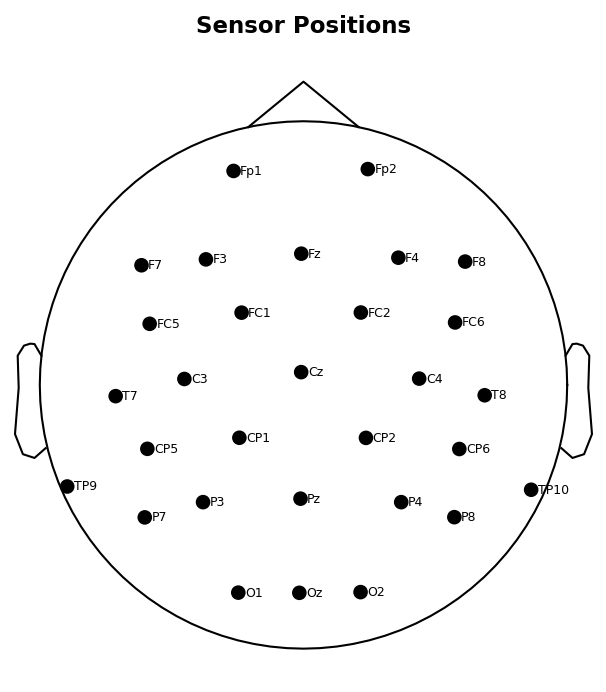

In [6]:
raw.set_montage(
    mne.channels.make_standard_montage("standard_1020"), 
    verbose=False
)
ax = raw.plot_sensors(
    show_names = True,
    sphere=(0, 0.02, 0, 0.1),
    show = False
).axes[0];
ax.set_title("Sensor Positions")
plt.sca(ax)
plt.show()

In [7]:
PLOT_SETTINGS = dict(
    n_channels=len(raw.ch_names),
    scalings=dict(
        eeg = 5e-5,
        misc = 2
    ),
    show = False,
)

In [8]:
if VISUAL_INSPECTION:
    fig = raw.compute_psd(
        fmax=60,
        remove_dc=False,
    ).plot()
    fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))

In [9]:
preview_segmentation = dict(
    begin = 90,
    end = 120
)

raw_preview_segment = raw.copy().crop(
    tmin = preview_segmentation["begin"],
    tmax = preview_segmentation["end"],
)

In [10]:
raw_filtered = raw.copy()

raw_filtered.filter(
    l_freq = 0.5, # pass everything over _ Hz
    h_freq = 40, # pass everything below _ Hz
    n_jobs = 4,
)

excluded_channels = {
    "group13_a": [
        "TP10"
    ],
    "group13_b": [

    ],
    "group13_c": [
        "FC1",
        "FC5",
        "CP2",
        "P3",
        "Pz",
    ],
}[SESSION]

raw_filtered.info["bads"] = excluded_channels

raw_filtered.pick(
    picks=raw.ch_names, 
    exclude="bads"
)

if VISUAL_INSPECTION:
    fig = raw_filtered.plot(
        start = preview_segmentation["begin"],
        duration = preview_segmentation["end"] - preview_segmentation["begin"],
        **PLOT_SETTINGS
    )
    fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.set_size_inches(12, 10)
    plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.7s finished


In [11]:
if VISUAL_INSPECTION:
    eog_epochs = mne.preprocessing.create_eog_epochs(
        raw, 
        h_freq = 2,
        baseline=(-0.3, -0.1)
    )
    eog_epochs.average().plot_joint(title = "Electrooculography");

In [12]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=0, max_iter=500)
ica.fit(raw_filtered)

if VISUAL_INSPECTION:
    ica.plot_components();
    fig = ica.plot_sources(
        raw_filtered,
        start = preview_segmentation["begin"],
        stop = preview_segmentation["end"],
        show = False,
    )
    fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.set_size_inches(12, 10)
    plt.show()

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components
Fitting ICA took 6.0s.


In [13]:
eog_indices, eog_scores = ica.find_bads_eog(
    raw_filtered, 
    measure = "correlation", 
    threshold = 2/3,
    verbose = False,
)

# override artifact components for participant where EOG was unavailable
if SESSION == "group13_c": 
    eog_indices = [3]

if VISUAL_INSPECTION:
    ica.plot_scores(eog_scores, exclude = eog_indices)

    fig = ica.plot_overlay(
        raw_filtered, 
        exclude = eog_indices,
        start = preview_segmentation["begin"] * 1000,
        stop = preview_segmentation["end"] * 1000,
    )
    fig.axes[2].xaxis.set_major_locator(ticker.MultipleLocator(5))
    fig.axes[2].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.show()

In [14]:
raw_processed = ica.apply(raw_filtered)

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 29 PCA components


In [15]:
raw_processed.interpolate_bads(mode = "accurate").pick("eeg")

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.1 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors


Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,30 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.50 Hz
Lowpass,40.00 Hz


In [16]:
raw_processed.set_eeg_reference(
    ref_channels = "average", 
    projection = False, 
    verbose = False
)

Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,30 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.50 Hz
Lowpass,40.00 Hz


In [17]:
import sys
sys.path.append("..")
from constants import EEG_EVENT_ENCODINGS

events, event_ids = mne.events_from_annotations(raw)

if VISUAL_INSPECTION:
    fig = mne.viz.plot_events(
        events, 
        event_id = EEG_EVENT_ENCODINGS,
        color = dict(),
        on_missing = "ignore",
        show = False,
        verbose = "ERROR"
    )
    fig.set_size_inches(9, 3)
    ax = fig.axes[0]
    for line in ax.get_lines():
        line.set_marker("|")
        line.set_markersize(4)

    ax.get_legend().remove()
    ax.set_yticklabels([f"{key}\n{(events[:,2] == code).sum()} instances" for key, code in EEG_EVENT_ENCODINGS.items()])
    plt.tick_params(
        axis="y", 
        which="both", 
        labelleft = False, 
        labelright = True,
        length = 0,
        pad = 15
    )
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)
    ax.set_title("Event Markers")
    plt.show()

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


In [18]:
epochs = mne.Epochs(
    raw_processed, 
    events,
    event_id = EEG_EVENT_ENCODINGS, 
    picks = "eeg",
    reject = dict(eeg = 150e-6), 
    tmin = -0.2, 
    tmax = 0.8,
    baseline = (-0.2, 0),
    preload = True,
    verbose = False
)
epochs.info

Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,30 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.50 Hz
Lowpass,40.00 Hz


In [19]:
print(f"{len([ep for ep in epochs.drop_log if len(ep)]) / len(events):.1%} of epochs were dropped")

8.8% of epochs were dropped


In [20]:
def get_response_times(conditions):
    event_codes = [EEG_EVENT_ENCODINGS["trial/" + event] for event in conditions]
    trials = np.where(np.isin(events[:,2], event_codes))[0]
    response_times = events[trials + 1][:-1,0] - events[trials][:-1,0]
    response_times = np.append(response_times, np.median(response_times))
    return sorted(np.divide(response_times, 1000))

def plot_sanity_check(name, conditions, sensors):
    epochs[conditions].plot_image(
        picks = sensors,
        title = f"""{name} ({", ".join(sensors)})\nConditional on Response Time""",
        overlay_times = get_response_times(conditions = conditions),
    )[0];

# if VISUAL_INSPECTION:
#     plot_sanity_check(
#         name = "Positive Feedback",
#         conditions = ["correct", "error rectified"], 
#         sensors = ["O2"]
#     )

#     plot_sanity_check(
#         name = "Negative Feedback",
#         conditions = ["incorrect", "error inserted"], 
#         sensors = ["O2"]
#     )

#     plot_sanity_check(
#         name = "Negative Feedback",
#         conditions = ["incorrect", "error inserted"], 
#         sensors = ["T7"]
#     )

#     plot_sanity_check(
#         name = "Inserted Errors",
#         conditions = ["error inserted"], 
#         sensors = ["Cz"]
#     )

In [21]:
if VISUAL_INSPECTION:
    epochs.average(picks = "eeg").plot_joint();

In [22]:
export_path = RAW_DATA_PATH.joinpath(SESSION + "-epo.fif")

epochs.pick("eeg").save(export_path, overwrite = True)
print(f"[INFO] Exported epochs to {export_path}")

Overwriting existing file.
Overwriting existing file.
[INFO] Exported epochs to ../data/EEG/group13_a-epo.fif


In [23]:
epochs.filter(l_freq = None, h_freq = 30, n_jobs = 4).pick("eeg").save(RAW_DATA_PATH.joinpath(SESSION + "_LPF_smoothed" + "-epo.fif"), overwrite = True)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 32764 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 124924 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 253948 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 300750 out of 300750 | elapsed:   28.3s finished


Overwriting existing file.
Overwriting existing file.
